In [75]:
import os
from os import path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [76]:
path_name = path.join(path.abspath('..'), 'data')
file_name = 'corrective_maint_job_types.csv'

data_file = path.join(path_name, file_name)

df = pd.read_csv(data_file)

In [77]:
df.head()

,notif,notif_date,floc,order,job_type,catalog_profile,meter_install_date,meter_model,network,postcode,...,weather_date,evapo_trans_0000_2400,rain_0900_0900,pan_evap_0900_0900,max_temp,min_temp,max_rel_humidity,min_rel_humidity,avg_10m_wind_speed,solar_radiation
0,300713965.0,2011-12-21,504107.0,NaN,SPH,MAIN,NaN,NaN,SM,6110.0,...,2011-12-21,7.3,0.0,NaN,28.9,13.6,97.0,32.0,3.87,34.47
1,300719006.0,2011-12-21,673096.0,NaN,SPL,MAIN,NaN,NaN,SM,6111.0,...,2011-12-21,7.9,0.0,NaN,30.6,16.4,82.0,35.0,4.24,34.47
2,300719010.0,2011-12-21,810841.0,NaN,SPH,MAIN,NaN,NaN,NM,6019.0,...,2011-12-21,NaN,NaN,NaN,25.8,NaN,91.0,61.0,4.63,34.24
3,300719430.0,2011-12-21,27.0,NaN,SPH,MAIN,NaN,NaN,NM,6026.0,...,2011-12-21,7.2,0.0,NaN,29.2,17.4,89.0,38.0,3.37,34.38
4,300730505.0,2011-12-21,117547.0,NaN,SF1,DOMMETER,14.01.2014,M8A,SM,6153.0,...,2011-12-21,7.3,0.0,NaN,28.9,13.6,97.0,32.0,3.87,34.47


In [78]:
pivot = df.pivot_table('notif', index='job_type', columns='network', aggfunc='count')
#pivot

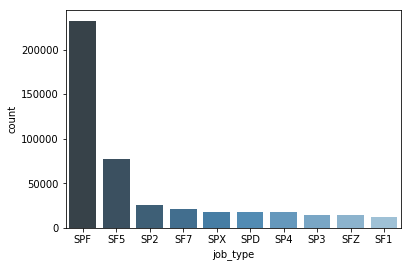

In [79]:
import seaborn
seaborn.countplot(df['job_type'],
                  palette="Blues_d",
                  order=df['job_type'].value_counts().iloc[:10].index
                 )


C:\Users\tdavies\AppData\Local\conda\conda\envs\VV_Forecasting\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


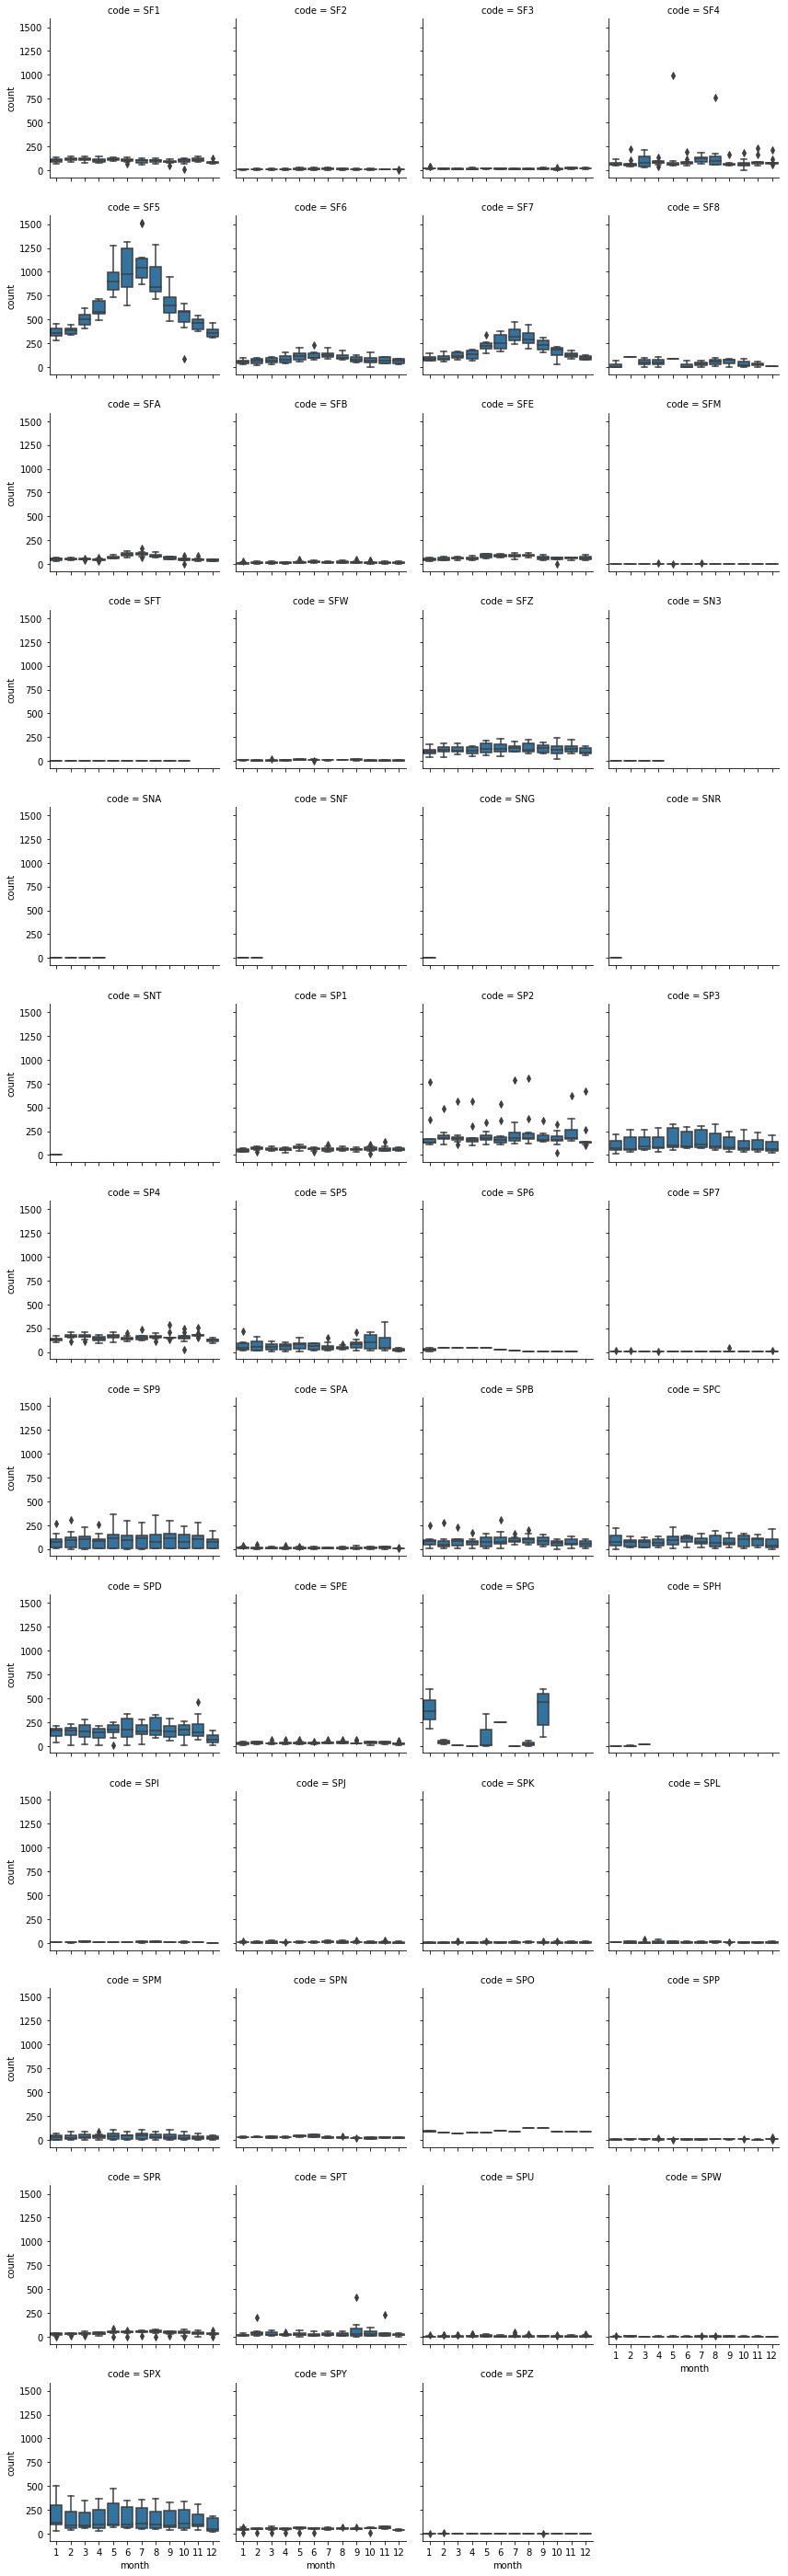

In [80]:
import pandas as pd
import seaborn as sns
from datetime import date
from datetime import time
from datetime import datetime

df['notif_date'] = pd.to_datetime(df['notif_date'])
new_df = df[['notif_date','job_type']]
new_df.set_index('notif_date')

monthly_data=[]
labels = ['code','year', 'month', 'count']

for cat, subcategories in new_df.groupby('job_type'):
    if cat!='SPF':
        job_type = cat
        for yr, year_df in subcategories.groupby(df['notif_date'].dt.year):
            for mnth, month_df in year_df.groupby(df['notif_date'].dt.month):
                new_data=[cat, yr, mnth, len(month_df)]
                #print(new_data)
                monthly_data.append(new_data)
            
       
output = pd.DataFrame.from_records(monthly_data, columns=labels)

g = sns.FacetGrid(output, col='code',  aspect=1, col_wrap=4)
g.map(sns.boxplot, 'month', 'count')

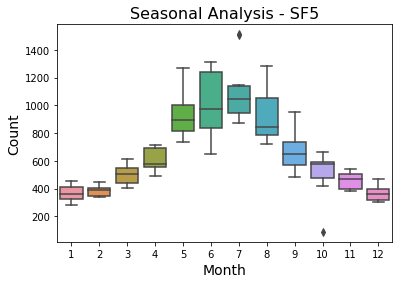

In [81]:
# add lineplot
job_type = 'SF5'
data = output.loc[output['code'] == job_type]
title = 'Seasonal Analysis - ' + job_type

plot = sns.boxplot(x='month', y='count', data=data)
#plot = sns.lineplot(x='month', y='count', data=data, color='blue').set_title(title)

# format plot
plot.axes.set_title("Seasonal Analysis - " + job_type, fontsize=16)
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Count", fontsize=14)
plot.tick_params(labelsize=10)

In [82]:
data.head()

,code,year,month,count
470,SF5,2009,1,335
471,SF5,2009,2,339
472,SF5,2009,3,403
473,SF5,2009,4,490
474,SF5,2009,5,735


In [83]:
monthly_output = new_df[new_df['job_type'] == 'SF5']

monthly_output['notif_date']=pd.to_datetime(monthly_output['notif_date'])
monthly_output['notif_date']=monthly_output['notif_date'].dt.strftime('%Y-%m')

monthly_output = monthly_output.pivot_table('job_type', index='notif_date', aggfunc='count')

monthly_output = monthly_output.reset_index()

C:\Users\tdavies\AppData\Local\conda\conda\envs\VV_Forecasting\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tdavies\AppData\Local\conda\conda\envs\VV_Forecasting\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [84]:
#monthly_output.head()

In [85]:
#_ = monthly_output.plot(x='notif_date', y='job_type', figsize=(12,4))

In [86]:
def AR(data, maxlag = 1):
    """
    Implements Autoregression (AR) 
    parameters:
        data: times series data
        maxlag: degree of the model (1 by default)
    return:
        X, y and b (A hat)
    """
    #linear model of order max lag 8)
    #data = df['sunspots'].values
    maxz = data.size  #to separete test and fit data, this should be reduced

    # Computing matrix X
    X = np.array([data[i:(maxz-maxlag-1)+i] for i in range(0, maxlag)])
    # Performing the transponse of X
    X = X.T

    # Computing matrix y
    y = np.array(data[maxlag+1:maxz])

    # Computing the Pseudo-Inverse of X (as X is a rectangular matrix)
    Xinv = np.linalg.pinv(X.copy())
    
    # Solving the linear system b = Xinv * y
    b = np.dot(Xinv, y)
    
    return (X, y, b)

In [87]:
def pred_local_constant_model(data, X, y, maxlag = 1, nstep = 100):
    """
    Implements yp = xi * b to predict nsteps
    parameters:
        data: times series data
        X: data representation
        y: value of the function for each row in X
        maxlag: degree of the model (1 by default)
        nstep: number of steps (100 by default)
    return:
        predictions
    """
        
    #now free-rn from a local constant model
    xinit = data[-maxlag-1:-1]
    xi = xinit
    step = 0
    yp = data[-1]

    #distance function
    dist = lambda x1, x2: math.sqrt(((x1-x2)**2).sum())

    while step < nstep:
        # 1) Compute the distance to the points xi with respect X
        xdm = [dist(xi,xj) for xj in X]
        
        # 2) Sort the distances, rather neat way of finding the second 
        #    smallest without doing a full sort
        ind = np.argpartition(xdm,2)[2]
        # 3) Find the second smallest value to predict the true future
        xp = y[ind]
        
        # update xi and yp
        xi = np.delete(xi,0)
        xi = np.append(xi,xp)
        yp = np.append(yp,xp)
        
        # increment and repeat steps 1, 2 and 3 until step == nstep
        step += 1
        
    return yp

In [108]:
# play with hyperparameters
maxlag = 3
nsteps = 365 # predict the next nsteps

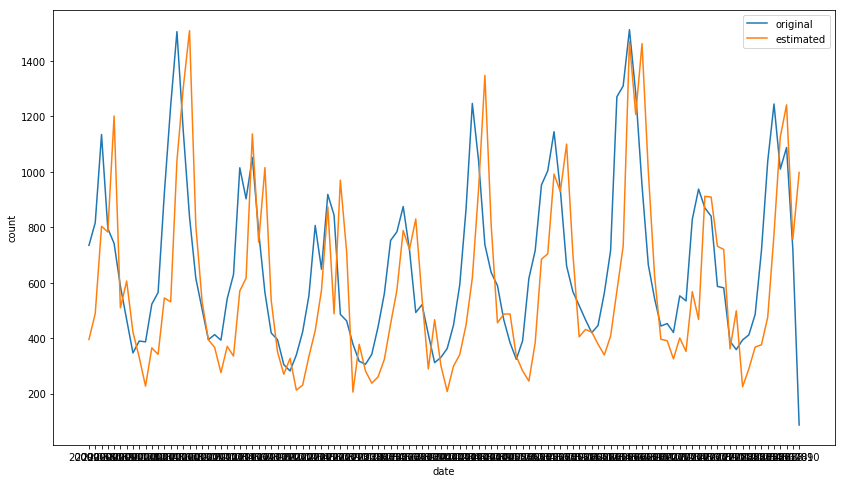

In [117]:
X, y, b = AR(monthly_output['job_type'].values, maxlag)
yp = np.dot(X, b)

plt.figure(figsize=(14,8))
#plt.plot(monthly_output['notif_date'][maxlag+1:], monthly_output['job_type'][maxlag+1:], label='raw')
plt.plot(monthly_output['notif_date'][maxlag+1:], y, label='original')
plt.plot(monthly_output['notif_date'][maxlag+1:], yp, label='estimated')
plt.xlabel('date')
plt.ylabel('count')
plt.legend()
plt.show()

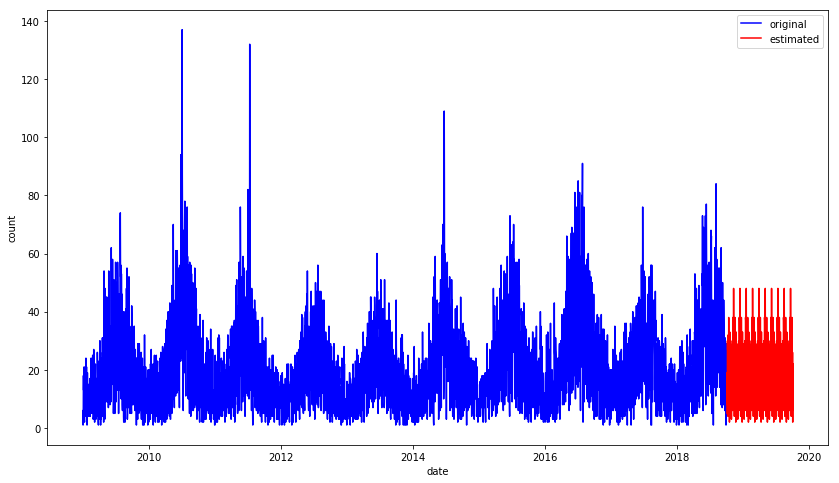

In [115]:
# Visualising the Predictions
from datetime import timedelta

# get daily time series data spefic to required job type
daily_output = new_df[new_df['job_type'] == 'SF5']
daily_output = daily_output.pivot_table('job_type', index='notif_date', aggfunc='count')
daily_output = daily_output.reset_index()

#Calculate the linear autoregressive model
X, y, b = AR(daily_output['job_type'].values, maxlag)
yp2 = pred_local_constant_model(daily_output['job_type'].values, X, y, maxlag, nsteps)

# Set up dataframe to capture output data in suitable format
columns = ['notif_date', 'job_type']
days = pd.DataFrame(index=daily_output.index, columns=columns)
days['notif_date'] = daily_output['notif_date']
pd.to_datetime(days['notif_date'])

# set up temporary dataframe to capture estimated values
estimates = pd.DataFrame()

# initiate start values for loop variables
next_date = daily_output['notif_date'].values[-1]
next_index = daily_output.index[-1]+1

# determine estimates for range
for i in range(nsteps+1):
    next_date = next_date + np.timedelta64(1,'D')
    next_count = yp2[i]
    estimate = [(next_date, next_count)]
    estimates = estimates.append(estimate)

# format dataframe to be in consistent format with days dataframe
estimates.columns = columns

# Append estimated values to actual values
days = days.append(estimates, ignore_index=True)

# Aggregate daily estimates to monthly estimates
#days['notif_date'] = days['notif_date'].dt.strftime('%Y-%m')
#days = days.pivot_table('job_type', index='notif_date', aggfunc='sum')
#days = days.reset_index()

# Aggregate daily actuals to monthly actuals
#daily_output['notif_date'] = pd.to_datetime(daily_output['notif_date'])
#daily_output['notif_date'] = daily_output['notif_date'].dt.strftime('%Y-%m')
#daily_output = daily_output.pivot_table('job_type', index='notif_date', aggfunc='sum')
#daily_output = daily_output.reset_index()

# Plot actual and forecast values
plt.figure(figsize=(14,8))
plt.plot(daily_output['notif_date'], daily_output['job_type'], c='b', label='original')
plt.plot(days['notif_date'], days['job_type'], c='r', label='estimated')
plt.xlabel('date')
plt.ylabel('count')
plt.legend()
plt.show()